# Minimum Variance Portfolio, sample cov using MLE linear shrinkage

Shrinkage algorithm implemented from 
    Ledoit, O., and M. Wolf, 2003, “Honey, I Shrunk the Sample Covariance Matrix,” Working
    Paper, Department of Economics and Business, Universitat Pompeu Fabra.
Access: https://ssrn.com/abstract=433840

The performance of the shrinkage estimator is measured in MSE terms of the covariance matrix estimate, using the matrix Frobenius norm

$ ||\hat{\Sigma}-\Sigma||_F = \sqrt{\sum_{i,j} (\hat{\sigma}^2_{ij} - \sigma^2_{ij})^2 }$.
 That is, the squared residual of the element-wise covariances.
 
While the shrinkage estimator is a biased estimator, it can archive a lower MSE than the unbiased sample covariance by having a lower variance.

## Define benchmark returns statistics

In [16]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy.stats as stats
import putils
import montecarlo as mc
import pmontecarlo as pmc
import present

# =========================
# ===== Daily Returns =====
# =========================
# Some 4 OMX stocks....
mcorr = np.array(
    [
        [1.00, 0.26, 0.41, 0.57],
        [0.26, 1.00, 0.19, 0.33],
        [0.41, 0.19, 1.00, 0.52],
        [0.57, 0.33, 0.52, 1.00]
    ])

vol = np.array([0.01531293, 0.01802784, 0.02480944, 0.01251876])
mcov = np.diag(vol) @ mcorr @ np.diag(vol)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Calculate measures based on benchmark return distribution

In [17]:
# TODO: move outside of main
# Used for estimating hedged portfolio variance, involing inverse of covariance matrix.
p = putils.Portfolio(np.array([1, 0, 0, 0]))
p_var = putils.portfolio_var(p, mcov)
hdg = putils.mvp_hedge(p, mcov)
mvp = p + hdg
mvp_var = putils.portfolio_var(mvp, mcov)

# === Covariance Frobenius Norm ===
norm_exact = np.linalg.norm(mcov, 'fro')

truevals = {'mvp.var':mvp_var, 'cov.relnorm':norm_exact, 'p.var':p_var}



## Simulate returns and estimate MVP

In [18]:
obs_gen = stats.multivariate_normal(cov=mcov)
T_grid = pmc.init_sparse_grid(lbound=mcorr.shape[0], max_sample_size = 64)
mc = mc.MonteCarlo(
    rndgen=lambda: obs_gen.rvs(T_grid[-1]),
    nsim=1000,
    evalfunc=lambda welfords,path : pmc.mc_path_eval(T_grid, p, mcov, welfords, path),
    welfords=pmc.estimations(len(T_grid))
    )
est = mc.run()

## Results

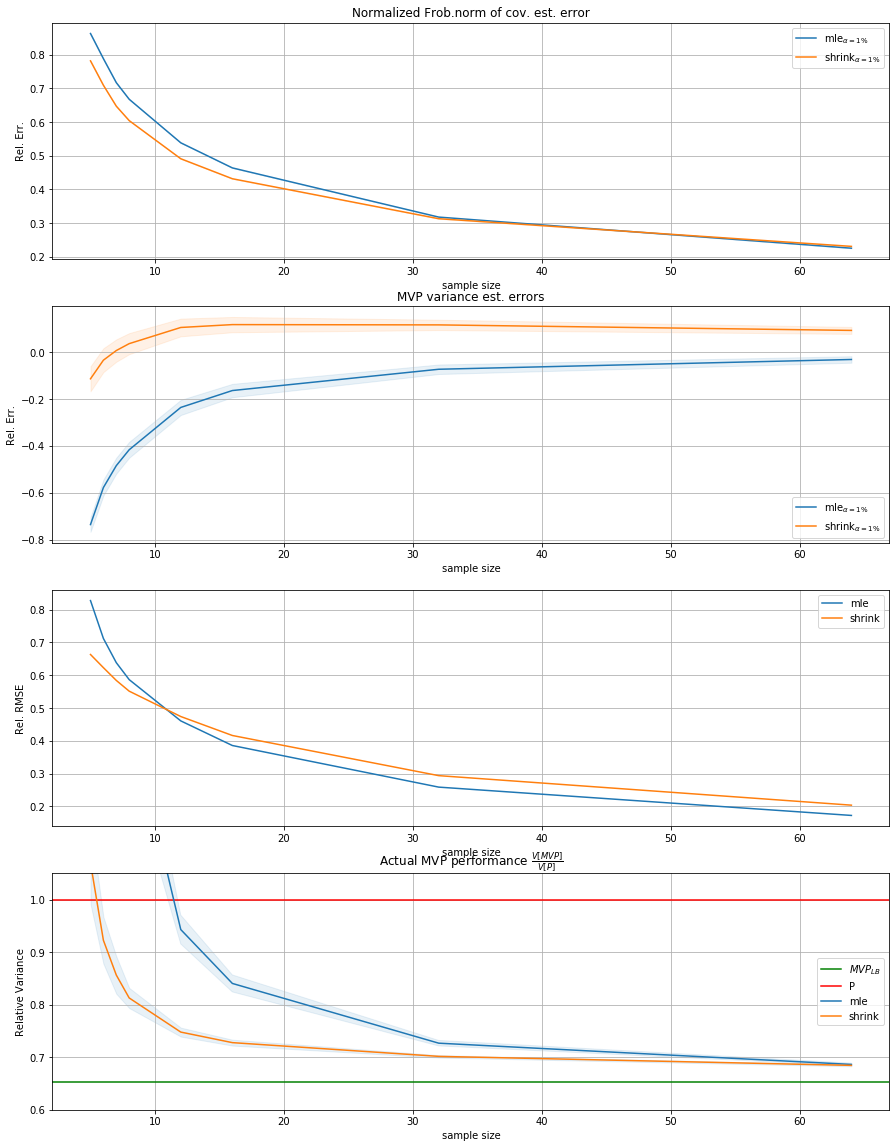

In [28]:
present.result(T_grid, est, truevals, alpha_conf = 0.01)

For the 4x4 covariance matrix, of which 3 are hedges, the shrinkage estimation outperforms sample covariance.
Surprisingly, the sample covariance has a lower Frobenius norm after around 30 samples (why?)...